In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
import os
os.chdir("drive/My Drive/Google_Colab_Drive/Custom_CallBacks_in_Keras")

In [3]:
!ls

Custom_CallBacks_Keras.ipynb


# Create a Custom Callback in Keras

In this notebook I am going to create a Custom CallBack Function and use it in Model training process. We will write the callback to perform 3 tasks, 

1. Write a log file in the disk and update it for the training metric during the training process.
2. Update the value of learning rate for each epoch.
3. Plot the training and validation accuracies in a graph during the training process. 



# Task 1: Importing Libraries

In [1]:
%matplotlib notebook

import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
# %matplotlib inline
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.1.0


# Task 2: Importing and Preprocessing Data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print ("Original Shape")
print(x_train.shape)
print(y_train.shape)
#Unrolling the Xs and (0-1) Normalization
print ("After Flattening, Shape")
x_train = np.reshape(np.ravel(x_train), (x_train.shape[0], -1))
print(x_train.shape)
x_test = np.reshape(np.ravel(x_test), (x_test.shape[0], -1))
print(x_test.shape)

11493376/11490434 [==============================] - 1s 0us/step
Original Shape
(60000, 28, 28)
(60000,)
After Flattening, Shape
(60000, 784)
(10000, 784)


In [3]:
# 0-1 Normalization
x_train = x_train/255.
x_test = x_test/255.

In [4]:
# one-hot encoding of y
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)
print(y_train[0])

(60000, 10)
(10000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


# Task 3: Creating the Model

In [5]:
model = tf.keras.models.Sequential([
                tf.keras.layers.Dense(16, activation='relu', input_shape = (784, )), 
                tf.keras.layers.Dense(10, activation='softmax')
])

opt = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics = ['accuracy']) # Loss is by-default included.  
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                12560     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________


# Tasks 4 & 5: Creating the Callback

In [6]:
# To write custom callback function we need to inherit the Callback class from tf.keras.callbacks and override the methods/functions to fit our need. 
class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self, fraction):
    '''
    fraction ==> float, would be used to change the learning rate, as the model training goes from one epoch to another. 
    '''
    super(CustomCallback, self).__init__()
    self.fraction = fraction
    self.training_acc = []
    self.validation_acc = []
    with open('log.txt', 'w') as f:
      f.write('Start of logging..\n')
    self.fig = plt.figure(figsize=(4,3))
    self.ax = plt.subplot(1,1,1)
    plt.ion()
  
  def on_train_begin(self, logs=None):
    self.fig.show()
    self.fig.canvas.draw()
  
  def on_train_end(self, logs=None):
    with open('log.txt', 'a') as f:
      f.write('End of logging..\n')
  
  def on_epoch_begin(self, epoch, logs=None):
    lr = tf.keras.backend.get_value(self.model.optimizer.lr) # getting the current learning rate of the optimizer
    lr *= self.fraction
    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # Setting the updated learning rate as the new learning rate of the optimizer.
    with open('log.txt', 'a') as f:
      f.write('At epoch {:02d}, learning rate changed to {:.4f}\n'.format(epoch, lr))
  
  def on_epoch_end(self, epoch, logs=None):
    val_acc = logs.get('val_accuracy')
    train_acc = logs.get('accuracy')

    self.validation_acc.append(val_acc)
    self.training_acc.append(train_acc)

    with open('log.txt', 'a') as f:
      f.write('At epoch {:02d}, training accuracy is {:.3f}, validation accuracy is {:.3f}\n'.format(epoch, train_acc, val_acc))
    
    self.ax.clear()
    self.ax.plot(range(1+epoch), self.training_acc, label = 'Training')
    self.ax.plot(range(1+epoch), self.validation_acc, label = 'Validation')
    self.ax.set_xlabel('Epochs')
    self.ax.set_ylabel('Accuracy')
    self.ax.legend()
    self.fig.canvas.draw()



# Task 6: Training the Model

<IPython.core.display.Javascript object>


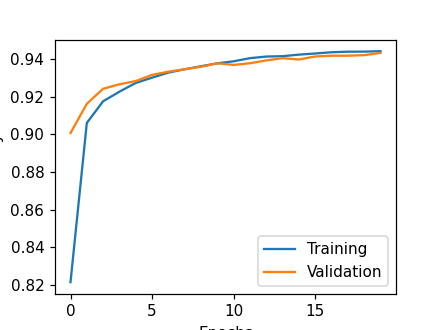

In [7]:
cc = CustomCallback(fraction = 0.9)

In [8]:
_ = model.fit(
    x_train, y_train,
    validation_data = (x_test, y_test), 
    epochs = 20,
    verbose = False,
    callbacks = [cc]
)